# Simulations (no model misspecification)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

import torch
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, Sigmoid
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR


from tukey import losses
from tukey.transforms import SoftPlusTransform
from tukey.models import NN

## Definition of neural network 

For this simulated data experiments, we use a simple neural network with a few dense layers. Note that the transformations that ensure that the outputs of the neural network are in the correct domain (i.e. positive for $\sigma$ and $h$ are in the loss class, not directly in the neural network.

In [8]:
nn = NN((1, 512, 512, 512), 4, batch_norm=False)  # 4 outputs required for G-and-H
nn_gaussian = NN((1, 512, 512, 512), 2, batch_norm=False)  # 2 outputs required for Gaussian
nn_parameters = nn.parameters()
nn_gaussian_parameters = nn_gaussian.parameters()

## Definition of the true model and simulation 

For our simulation study, we consider a very simple regression problem of a scalar target $Y$ in terms of a scalar feature $X$. The true conditional distribution of $Y$ given $X$ is defined according to the following equation,

\begin{equation}
    Y | X \sim \mu(X) + \sigma(X) \tau_{g(X), h(X)}(Z),
\end{equation}
where the functions $\mu(\cdot)$, $\sigma(\cdot)$, $g(\cdot)$ and $h(\cdot)$ are defined arbitrarily --- see the functioon $f$ defined in the code portion below. The random variable $Z$ is standard normal, $Z\sim\mathcal{N}(0, 1)$, while $\tau_{g,h}$ is the tukey $g$ and $h$ transform.

For our simulations we sample $X$ according to a uniform distribution on the interval $[0, 1]$.

In [3]:
# data parameters
N_SAMPLES = 40000
TRAIN_SPLIT = int(N_SAMPLES * 0.8)
MISSPECIFIED = False

# training parameters
BATCH_SIZE = 1024
N_EPOCHS=50

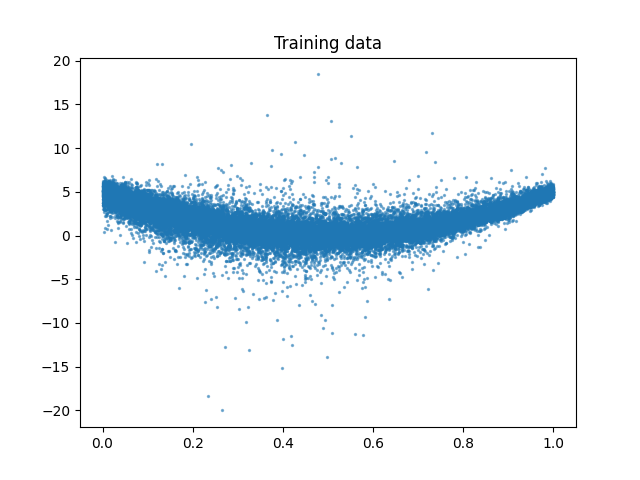

In [5]:
def f(x: float) -> tuple:
    """Function providing the 4 parameters (mu, beta, g, h) of the transformation applied to 
    a standard normal variable given the input x. Chosen arbitrarily for the simulation.
    """
    return 20 * (x - 0.5) ** 2, 1 + 3 * (x - 0.25)**2, 1 / 2 * (x - 0.5), np.maximum(0, 0.25 - (x - 0.5)**2)

def f_tdist(x:float) -> tuple:
    """Function providing the 3 parameters of the t-distribution for the misspecified section of
    the simulation study"""
    df = 1.5 * x + 2
    loc = 4 * x**2
    scale = 0.2 + (x - 0.5)**2
    return df, loc, scale
    

def tukey_g_h(z: float, theta: tuple):
    """Applies the tukey-g-h transform with parameters theta to z."""
    mu, beta, g, h = theta
    z_tilda = 1 / g * (np.exp(g * z) - 1) * np.exp(h * z**2 / 2)
    return mu + 1 / beta * z_tilda

def t_dist(z: float, theta):
    df, loc, scale = theta
    return t(df, loc, scale).rvs()

if MISSPECIFIED:
    f = f_tdist
    true_dist = t_dist
else:
    true_dist= tukey_g_h

x_data = np.random.rand(N_SAMPLES).astype(np.float32)
#x_data = np.random.rand(N_SAMPLES).astype(np.float32)

theta = f(x_data)

z = np.random.randn(N_SAMPLES).astype(np.float32)
y_data = true_dist(z, theta)

x_data, x_data_val = x_data[:TRAIN_SPLIT], x_data[TRAIN_SPLIT:]
y_data, y_data_val = y_data[:TRAIN_SPLIT], y_data[TRAIN_SPLIT:]

#y_data = t_dist(x_data)

%matplotlib widget
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_data, y_data, s=2, alpha=0.5)
_ = ax.set_title('Training data')

## Training 

We declare a Tukey g-and-h loss and a Gaussian loss.

In [9]:
loss = losses.TuckeyGandHloss(n_target_channels=1, hmax=2)
loss_gaussian = losses.GaussianLoss(n_target_channels=1)

x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data).reshape((-1, 1))
x_val_torch, y_val_torch = torch.tensor(x_data_val).reshape((-1, 1)), torch.tensor(y_data_val).reshape((-1, 1))

dataset = TensorDataset(x_torch, y_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch)
optimizer = Adam(nn_parameters, lr=1e-4)
optimizer_gaussian = Adam(nn_gaussian_parameters, lr=1e-4)

scheduler = StepLR(optimizer, step_size=20)
scheduler_gaussian = StepLR(optimizer_gaussian, step_size=20)

In [10]:
tukey_losses = dict(train = [], val = [])
gaussian_losses = dict(train = [], val = [])

def train_for_one_epoch(nn, dataset):
    nn.train()
    nn_gaussian.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    batch_losses = []
    batch_losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        batch_losses.append(loss_y_yhat.detach().item())
        # gaussian
        optimizer_gaussian.zero_grad()
        y_hat = nn_gaussian(x)
        loss_y_yhat = loss_gaussian(y_hat, y)
        loss_y_yhat.backward()
        optimizer_gaussian.step()
        batch_losses_gaussian.append(loss_y_yhat.detach().item())
    print('Train losses: ', np.mean(batch_losses), np.mean(batch_losses_gaussian))
    tukey_losses['train'].append(np.mean(batch_losses))
    gaussian_losses['train'].append(np.mean(batch_losses_gaussian))
    scheduler.step()
    scheduler_gaussian.step()
    
    nn.eval()
    nn_gaussian.eval()
    dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
    batch_losses = []
    batch_losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            batch_losses.append(loss_y_yhat.detach().item())
            y_hat = nn_gaussian(x)
            loss_y_yhat = loss_gaussian(y_hat, y)
            batch_losses_gaussian.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(batch_losses), np.mean(batch_losses_gaussian))
    tukey_losses['val'].append(np.mean(batch_losses))
    gaussian_losses['val'].append(np.mean(batch_losses_gaussian))



for i_epoch in range(N_EPOCHS):
    train_for_one_epoch(nn, dataset)

Train losses:  1.396695464849472 1.3479712642729282
Validation losses:  1.2036551535129547 1.1556703746318817
Train losses:  1.1140467450022697 1.1032314412295818
Validation losses:  1.066036507487297 1.0861351042985916
Train losses:  1.036320500075817 1.0648762695491314
Validation losses:  1.0089351162314415 1.054472416639328
Train losses:  0.9537438601255417 1.0259129628539085
Validation losses:  0.8907518684864044 1.0031638443470001
Train losses:  0.7843662239611149 0.9564853180199862
Validation losses:  0.6499335989356041 0.9056380838155746
Train losses:  0.533001615665853 0.8211266789585352
Validation losses:  0.43291380256414413 0.7242385521531105
Train losses:  0.4309285543859005 0.633253138512373
Validation losses:  0.4059506617486477 0.5623300224542618
Train losses:  0.4129782384261489 0.5382155412808061
Validation losses:  0.39129506424069405 0.533340573310852
Train losses:  0.40702110528945923 0.5274913441389799
Validation losses:  0.39025725796818733 0.5309858433902264
Trai

Train losses:  0.4075589394196868 0.537085771560669
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.4193147234618664 0.5342355333268642
Train losses:  0.4135591499507427 0.5415594410151243
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.4191942363977432 0.5334544815123081
Train losses:  0.4077877067029476 0.537345526739955
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.41920215263962746 0.5334252752363682
Train losses:  0.4094328647479415 0.5386723168194294
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.41921163722872734 0.5334645248949528
Train losses:  0.40952908899635077 0.5403531827032566
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Va

## Plot losses 

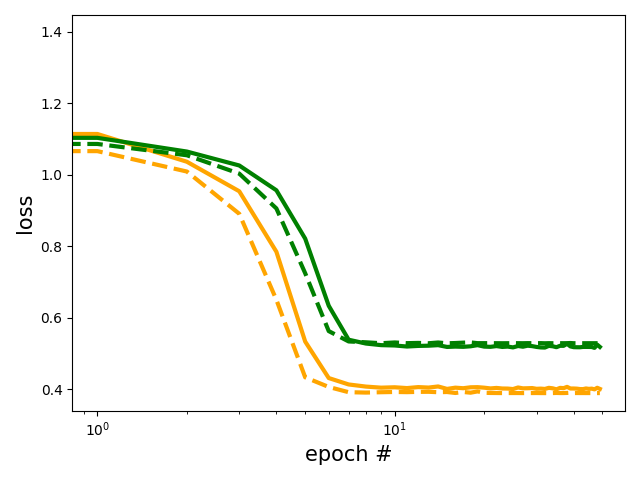

In [11]:
plt.figure()
plt.plot(tukey_losses['train'], color='orange', linewidth=3)
plt.plot(tukey_losses['val'], color='orange', linestyle='--', linewidth=3)

plt.plot(gaussian_losses['train'], color='green', linewidth=3)
plt.plot(gaussian_losses['val'], color='green', linestyle='--', linewidth=3)
plt.xscale('log')
plt.xlabel('epoch #', fontsize=15)
plt.ylabel('loss', fontsize=15)
#plt.ylim(None, 0.5)
plt.tight_layout()

plt.savefig('lossplot.png', dpi=800)

## Analysis 

For analysis, we plot the 4 functions of $x$ that make up the true model (solid lines) and the values predicted by the neural network (dashed lines).

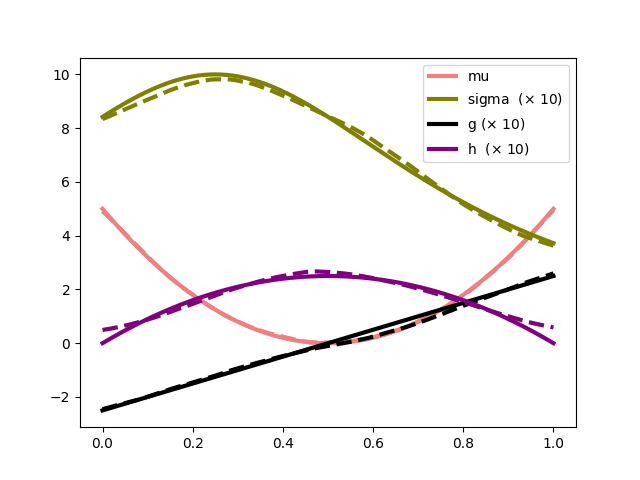

In [12]:
x_plot = np.linspace(min(x_data), max(x_data), 1000).astype(np.float32)
x_plot = x_plot.reshape((-1, 1))
# true regressed values
mu, beta, g, h = f(x_plot)

# predict g-and-h distributions for x_plot values
nn.eval()
with torch.no_grad():
    theta_plot = loss.predict(nn(torch.from_numpy(x_plot)))

mu_hat, beta_hat, g_hat, h_hat = theta_plot

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, mu, color='lightcoral', label='mu', linewidth=3)
ax.plot(x_plot, mu_hat, color='lightcoral', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 / beta, color='olive', label=r'sigma  ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 / beta_hat, color='olive', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 * g, color='k', label=r'g ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 *g_hat, color='k', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 * h, color='purple', label=r'h  ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 * h_hat, color='purple', linestyle='--', linewidth=3)

ax.legend()

#ax.set_title('test')
plt.savefig('tukey1.png', dpi=800)

We now plot the true conditional distributions for 4 values of the feature $x$ (blue), the G-and-H distribution predicted by the neural network for these same 4 values of the feature (orange), and the Gaussian distributions predicted by a separate neural network trained for that purpose using negative Gaussian likelihood for the loss function (green)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


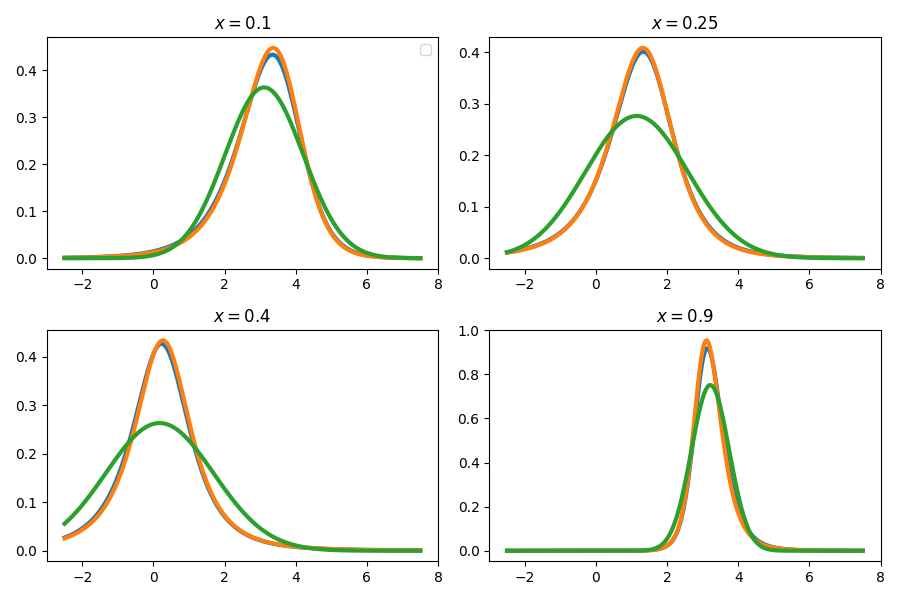

In [13]:
from tukey.utils import compute_pdf_tukey
from scipy.stats import norm

x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(9, 6))
z_tildas = torch.linspace(-2.5, 7.5, 1000)


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(2, 2, i + 1)
    x = x_0

    theta_true = f(x)
    with torch.no_grad():
        theta_pred = tuple([a.item() for a in loss.predict(nn(torch.tensor(x).reshape((-1, 1))))])
        theta_gaussian_pred = tuple([a.item() 
                                     for a in loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))])

    # true
    if not MISSPECIFIED:
        zz = (z_tildas - theta_true[0]) * theta_true[1]
        pdf_true = compute_pdf_tukey(zz, theta_true[2], theta_true[3]) * theta_true[1]
        plt.plot(z_tildas, pdf_true, linewidth=3)
    else:
        true_dist = t(df=theta_true[0], loc=theta_true[1], scale=theta_true[2])
        plt.plot(z_tildas, true_dist.pdf(z_tildas), linewidth=3)
    # pred tukey
    zz = (z_tildas - theta_pred[0]) * theta_pred[1]
    pdf_pred = compute_pdf_tukey(zz, theta_pred[2], theta_pred[3]) * theta_pred[1]
    plt.plot(z_tildas, pdf_pred, linewidth=3)
    # pred gaussian
    zz = (z_tildas - theta_gaussian_pred[0]) * theta_gaussian_pred[1]
    pdf_gaussian = norm.pdf(zz) * theta_gaussian_pred[1]
    plt.plot(z_tildas, pdf_gaussian, linewidth=3)
    #ax.set_yscale('log')
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()
if MISSPECIFIED:
    plt.savefig('tukey2bis.png', dpi=800)
else:
    plt.savefig('tukey2.png', dpi=800)

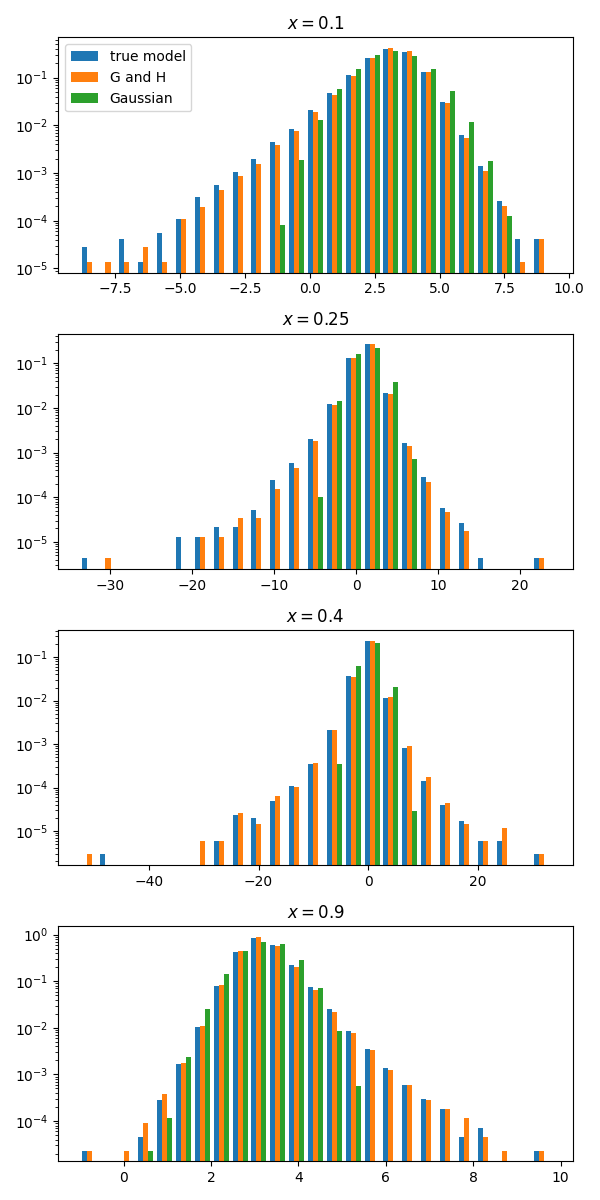

In [14]:
from tukey.utils import compute_pdf_tukey

n_points = 100000
x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(6, 12))


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(4, 1, i + 1)
    x = x_0 * np.ones(n_points, dtype=np.float32).reshape((-1, 1))
    z = np.random.randn(n_points).reshape((-1, 1))
    z2 = np.random.randn(n_points).reshape((-1, 1))


    theta_true = f(x)
    with torch.no_grad():
        theta_pred = loss.predict(nn(torch.tensor(x).reshape((-1, 1))))
        theta_gaussian_pred = loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))
    y_true = true_dist(z, theta_true)
    #y_true = t_dist(x.reshape((1, -1))).reshape((-1, 1))

    y_pred = tukey_g_h(z, theta_pred)
    y_gaussian_pred = theta_gaussian_pred[0] + 1 / theta_gaussian_pred[1] * z

    ax.hist(np.hstack((y_true, y_pred, y_gaussian_pred)), 
            bins=25, density=True, cumulative=False, log=True,
            label=('true model', 'G and H', 'Gaussian'))
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()

For a more rigurous analysis, we can compare the distribution of the $\hat{z}_i$'s to that of a standard normal.

In [15]:
import tukey.losses as ll

with torch.no_grad():
    theta_hat = loss.predict(nn(torch.from_numpy(x_data_val.reshape((-1, 1)))))
    mu, beta, g, h = theta_hat
    z_tilda = (torch.from_numpy(y_data_val.reshape((-1, 1))) - mu) * beta
    z_hat = ll.Tuckey_g_h_inverse.forward(None, z_tilda, g, h)

z_hat = z_hat.numpy()

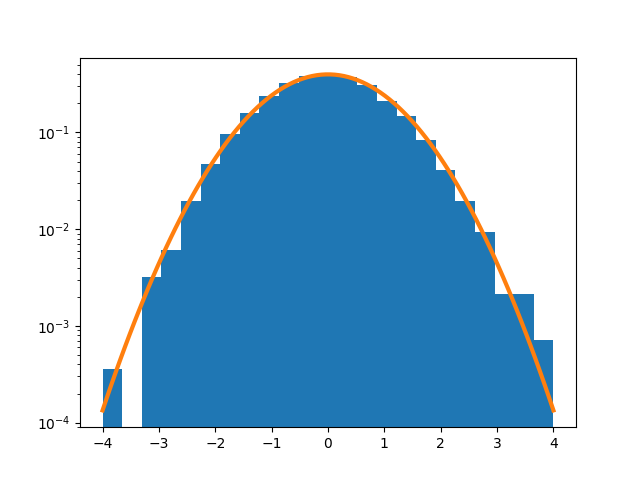

In [16]:
from scipy.stats import norm

plt.figure()
plt.hist(z_hat, bins=np.linspace(-4, 4, 24), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)), linewidth=3)
plt.yscale('log')
plt.savefig('residual_t.jpg', dpi=800)

We do a QQ plot to compare to the standard normal distribution.

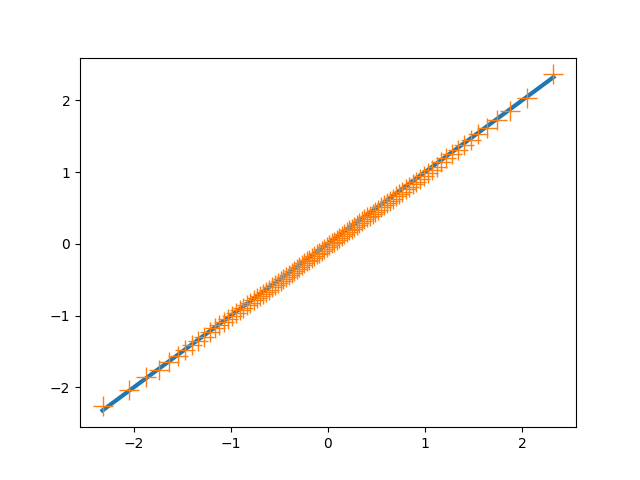

In [17]:
q = np.linspace(0, 1, 100)[1: -1]
true_quantiles = norm.ppf(q)
data_quantiles = np.quantile(z_hat, q)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(true_quantiles, true_quantiles, linewidth=3)
ax.plot(true_quantiles, data_quantiles, '+', markersize=15)

## Prediction confidence intervals 

One can easily obtain prediction confidence intervals from the trained neural network (even though these are not as rigurous as prediction confidence intervals understood in statistical terms, where one also accounts for the uncertainty in the parameter estimates - here this would correspond to the uncertainty in the parameters of the neural network, which could be approached by Bayesian NN or Bootstrapping??).

In [18]:
confidence_level = 0.5
x_plot = np.linspace(min(x_data), max(x_data), 256).astype(np.float32).reshape((-1, 1))

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

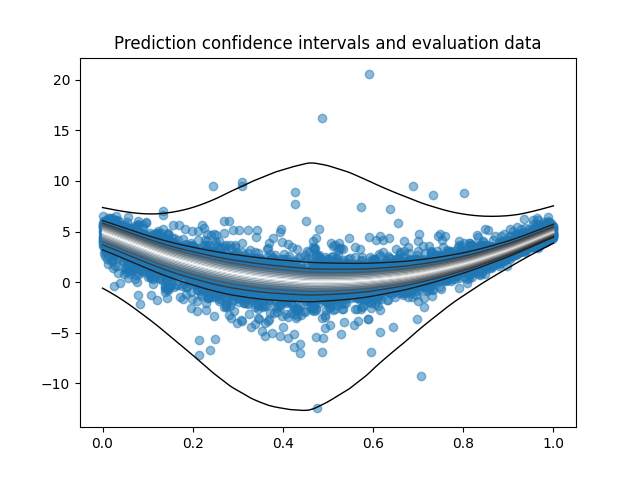

In [19]:
plt.figure()

for confidence_level in np.linspace(0.001, 0.999, 10):
    with torch.no_grad():
        lb, ub = loss.predict_ci(nn(torch.from_numpy(x_plot)), confidence_level)
        lb = lb.numpy()
        ub = ub.numpy()
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')